In [1]:
import numpy as np
import os,re
import sklearn.datasets as skd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
import time
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

In [200]:
class MLP_ODE(keras.Model):
    """Multi-layer NN ode_fn."""
    def __init__(self, num_hidden, num_layers, num_output,num_cond=2,name='mlp_ode'):
        super(MLP_ODE, self).__init__()
        self._num_hidden = num_hidden
        self._num_output = num_output
        self._num_layers = num_layers
        self._num_cond = num_cond
        self._modules = []
        
        #Fully connected layers with tanh activation and linear output
        self._modules.append(Input(shape=(1+self._num_output+self._num_cond))) #time is part of the inputs
        for _ in range(self._num_layers - 1):
            self._modules.append(layers.Dense(self._num_hidden,activation='tanh'))
            
        self._modules.append(layers.Dense(self._num_output,activation=None))
        self._model = keras.Sequential(self._modules)

        if self._num_cond > 1:
            #In more dimensiona, is useful to feed the conditional distributions after passing through an independent network model
            self._cond_model = keras.Sequential(
                [
                    Input(shape=(self._num_cond)),
                    layers.Dense(self._num_hidden,activation='relu'),
                    layers.Dense(self._num_cond,activation=None),
                ])
        
    @tf.function
    def call(self, t, data,conditional_input=None):
        if self._num_cond==1:
            #No network for a single feature
            cond_transform=tf.cast(conditional_input,dtype=tf.float32)
        else:
            cond_transform = self._cond_model(conditional_input)
            
        t = t*tf.ones([data.shape[0],1])
        inputs = tf.concat([t, data,cond_transform], -1)
        return self._model(inputs)
    

def make_bijector_kwargs(bijector, name_to_kwargs):
    #Hack to pass the conditional information through all the bijector layers
    if hasattr(bijector, 'bijectors'):
        return {b.name: make_bijector_kwargs(b, name_to_kwargs) for b in bijector.bijectors}
    else:
        for name_regex, kwargs in name_to_kwargs.items():
            if re.match(name_regex, bijector.name):
                return kwargs
    return {}

        
class FFJORD(keras.Model):
    def __init__(self, stacked_mlps, batch_size,num_output,name='FFJORD'):
        super(FFJORD, self).__init__()
        self._num_output=num_output
        self._batch_size = batch_size 
        ode_solve_fn = tfp.math.ode.DormandPrince(atol=1e-5).solve
        #Gaussian noise to trace solver
        trace_augmentation_fn = tfb.ffjord.trace_jacobian_hutchinson
        #trace_augmentation_fn = tfb.ffjord.trace_jacobian_exact
        
        bijectors = []
        for imlp,mlp in enumerate(stacked_mlps):
            ffjord = tfb.FFJORD(
                state_time_derivative_fn=mlp,
                ode_solve_fn=ode_solve_fn,
                trace_augmentation_fn=trace_augmentation_fn,
                name='bijector{}'.format(imlp) #Bijectors need to be names to receive conditional inputs
            )
            bijectors.append(ffjord)

        #Reverse the bijector order
        self.chain = tfb.Chain(list(reversed(bijectors)))

        self.loss_tracker = keras.metrics.Mean(name="loss")
        #Determien the base distribution
        self.base_distribution = tfp.distributions.MultivariateNormalDiag(
            loc=self._num_output*[0.0], scale_diag=self._num_output*[1.0]
        )
        
        self.flow=self.Transform()
        self._variables = self.flow.variables
        
    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]
    
    @tf.function
    def call(self, inputs, conditional_input=None):
        kwargs = make_bijector_kwargs(self.flow.bijector,{'bijector.': {'conditional_input':conditional_input }})
        return self.flow.bijector.forward(inputs,**kwargs)
    
    @tf.function
    def conditional_inverse(self, inputs, conditional_input):
        kwargs = make_bijector_kwargs(self.flow.bijector,{'bijector.' : {'conditional_input' : conditional_input}})
        return self.flow.bijector.inverse(inputs, **kwargs)
            
    def Transform(self):        
        return tfd.TransformedDistribution(distribution=self.base_distribution, bijector=self.chain)

    
    @tf.function
    def log_loss(self,_x,_c):
        loss = -tf.reduce_mean(self.flow.log_prob(
            _x,
            bijector_kwargs=make_bijector_kwargs(
                self.flow.bijector, {'bijector.': {'conditional_input': _c}})                                      
        ))
        
        return loss
    
    @tf.function
    def conditional_prob(self,_x,_c):
        return self.flow.prob(
            _x,
            bijector_kwargs=make_bijector_kwargs(
                self.flow.bijector, {'bijector.': {'conditional_input': _c}})                                      
        )
    
    @tf.function
    def conditional_log_prob(self,_x,_c):
        return self.flow.log_prob(
            _x,
            bijector_kwargs=make_bijector_kwargs(
                self.flow.bijector, {'bijector.': {'conditional_input': _c}})                                      
        )
    
    
    @tf.function()
    def train_step(self, values):
        #Full shape needs to be given when using tf.dataset
        data = values[:self._batch_size,:self._num_output]
        cond = values[:self._batch_size,self._num_output:]
        data.set_shape((self._batch_size,self._num_output))
        cond.set_shape((self._batch_size,cond.shape[1]))

        with tf.GradientTape() as tape:
            loss = self.log_loss(data,cond)
            
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}
    
    @tf.function
    def test_step(self, values):
        data = values[:self._batch_size,:self._num_output]
        cond = values[:self._batch_size,self._num_output:]
        data.set_shape((self._batch_size,self._num_output))
        cond.set_shape((self._batch_size,cond.shape[1]))
        
        loss = self.log_loss(data,cond)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


In [205]:
LR = 1e-2
NUM_EPOCHS = 20
STACKED_FFJORDS = 4 #Number of stacked transformations
NUM_LAYERS = 8 #Hiddden layers per bijector
NUM_OUTPUT = 2 #Output dimension
NUM_HIDDEN = 4*NUM_OUTPUT #Hidden layer node size
NUM_COND = 1 #Number of conditional dimensions

#Target dataset: half moon
DATASET_SIZE = 1024 * 8
BATCH_SIZE = 256 

# Generate conditional values from the uniform distribution [0,1]
constrain = np.random.uniform(0, 1, (DATASET_SIZE,1))

# Generate samples from Gaussians centered at the conditional value with std 1
samples = np.empty([DATASET_SIZE,2]).astype(np.float32)
for i in range(len(constrain)):
    samples[i] = np.random.normal(constrain[i], 1, (1,2))

print(samples.shape)
print(constrain.shape)
    
#samples= np.concatenate(
#(
#    np.random.normal(0.,0.5,(DATASET_SIZE//2,2)),
#    np.random.normal(-3.,0.5,(DATASET_SIZE//2,2)),
#),0).astype(np.float32)

#constrain = np.concatenate(
#    (np.ones((DATASET_SIZE//2,1)),np.zeros((DATASET_SIZE//2,1))),0).astype(np.float32)

# Continuous conditional distribution
#constrain = np.concatenate(
#    (np.random.normal(0, 0.5, (DATASET_SIZE//2, 1)), np.random.normal(1, 0.5, (DATASET_SIZE//2, 1))),0).astype(np.float32)
# constrain = np.random.normal(0, 1, (DATASET_SIZE,1)).astype(np.float32)

samples = np.concatenate([samples,constrain],-1) #Last dimensions are the conditional values
print(samples)

# Example of np.concatenate(xxx, -1):
# a = np.array([[1, 2], [3, 4]])
# b = np.array([[5, 6], [7, 8]])
# np.concatenate([a, b], -1)
# >>> array([[1, 2, 5, 6],
#.           [3, 4, 7, 8]])



#Stack of bijectors 
stacked_mlps = []
for _ in range(STACKED_FFJORDS):
    mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT,NUM_COND)
    stacked_mlps.append(mlp_model)

#Create the model
model = FFJORD(stacked_mlps,BATCH_SIZE,NUM_OUTPUT)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR))

history = model.fit(
    samples,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
)

NSAMPLES = DATASET_SIZE
#Sample the learned distribution
transformed = model.flow.sample(
    NSAMPLES,
    bijector_kwargs=make_bijector_kwargs(
        model.flow.bijector, {'bijector.': {'conditional_input': constrain}})
)

transformed_first = model.flow.sample(
    NSAMPLES,
    bijector_kwargs=make_bijector_kwargs(
        model.flow.bijector, {'bijector.': {'conditional_input': np.ones((NSAMPLES,1),dtype=np.float32)}})
)

transformed_second = model.flow.sample(
    NSAMPLES,
    bijector_kwargs=make_bijector_kwargs(
        model.flow.bijector, {'bijector.': {'conditional_input': np.zeros((NSAMPLES,1),dtype=np.float32)}})
)

(8192, 2)
(8192, 1)
[[ 0.96498722  1.08448768  0.93070434]
 [ 0.50736433  0.37690106  0.01687253]
 [ 1.32153904  0.44185278  0.72020017]
 ...
 [ 1.54310977  2.76773262  0.34224463]
 [-0.02719464  2.13384342  0.97728995]
 [-0.22694539  0.78489846  0.1163238 ]]
Epoch 1/20
32/32 [==============================] - 94s 191ms/step - loss: 2.9283
Epoch 2/20
32/32 [==============================] - 6s 200ms/step - loss: 2.8605
Epoch 3/20
32/32 [==============================] - 7s 210ms/step - loss: 2.8620
Epoch 4/20
32/32 [==============================] - 7s 216ms/step - loss: 2.8561
Epoch 5/20
32/32 [==============================] - 7s 212ms/step - loss: 2.8489
Epoch 6/20
32/32 [==============================] - 7s 218ms/step - loss: 2.8503
Epoch 7/20
32/32 [==============================] - 7s 210ms/step - loss: 2.8501
Epoch 8/20
32/32 [==============================] - 7s 210ms/step - loss: 2.8550
Epoch 9/20
32/32 [==============================] - 7s 228ms/step - loss: 2.8480
Epoch 10/2

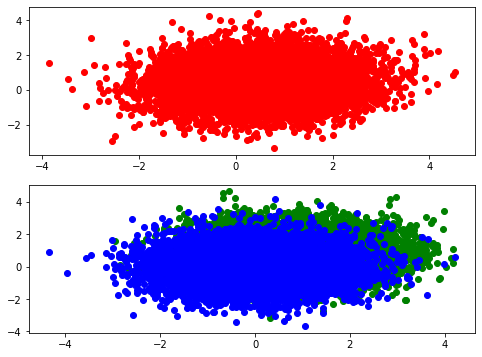

In [206]:
fig = plt.figure(figsize=(8, 6))
plt.subplot(211)    
plt.scatter(transformed[:, 0], transformed[:, 1], color="r")
plt.subplot(212)
plt.scatter(transformed_first[:, 0], transformed_first[:, 1], color="g", alpha=1)
plt.scatter(transformed_second[:, 0], transformed_second[:, 1], color="b", alpha=1)

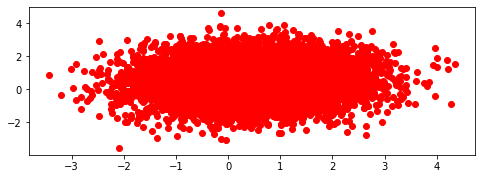

In [208]:
fig_samples = plt.figure(figsize=(8, 6))
plt.subplot(211)    
plt.scatter(samples[:, 0], samples[:, 1], color="r")

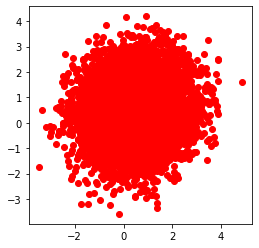

In [130]:
fig3 = plt.figure(figsize=(4, 4))
plt.scatter(transformed[:, 0], transformed[:, 1], color="r")

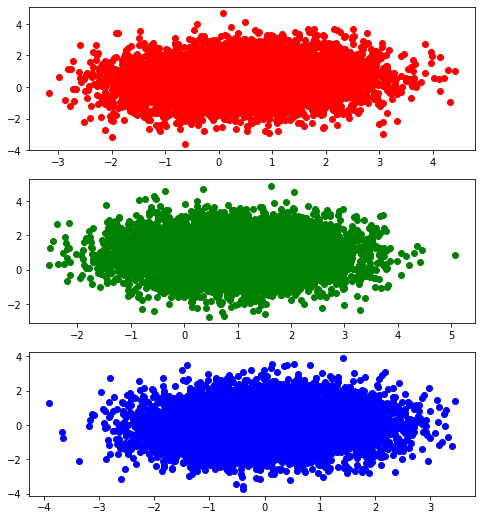

In [38]:
fig = plt.figure(figsize=(8, 9))
plt.subplot(311)    
plt.scatter(transformed[:, 0], transformed[:, 1], color="r")
plt.subplot(312)
plt.scatter(transformed_first[:, 0], transformed_first[:, 1], color="g")
plt.subplot(313)
plt.scatter(transformed_second[:, 0], transformed_second[:, 1], color="b")

In [180]:
# Maximum likelihood estimate: find the most probable conditional
# value z for a given data point x.

random_index = np.random.randint(DATASET_SIZE)
#random_index = 0
random_point = transformed[random_index]

N = 100

random_points = np.repeat([random_point], N).reshape((N,2))
zs = np.array([i/N for i in range(N)]).reshape((N,1))
log_probs = model.conditional_log_prob(random_points, zs)

#print(random_points, zs, probs)

#for i in range(N):
#    print(i/N)
#    probs[i] = model.conditional_log_prob([random_point], [[i/N]])
max_prob = np.amax(log_probs)
max_index = np.argmax(log_probs)

c_max = max_index / N

print(random_point,c_max)

tf.Tensor([ 0.06029534 -0.89777315], shape=(2,), dtype=float32) 0.47


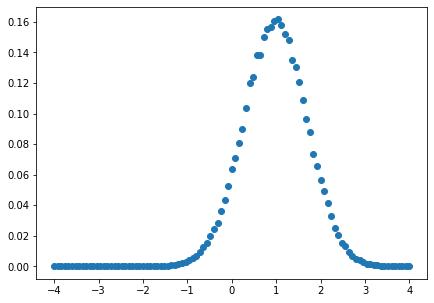

In [184]:
# Step 1: Plot p(x|z) for some z. 
# Verify that we indeed get a normal distribution.
# Here c=1.

xs = np.linspace(-4,4,101)
xs_2D = np.stack([xs, xs]).T.astype(np.float32)
zs = np.ones((101,1), dtype=np.float32)
#print(xs_2D)
#print(xs_2D.shape, zs.shape)
probs = model.conditional_prob(xs_2D, zs)
fig_xs_1 = plt.figure(figsize=(7,5))
plt.scatter(xs, probs)

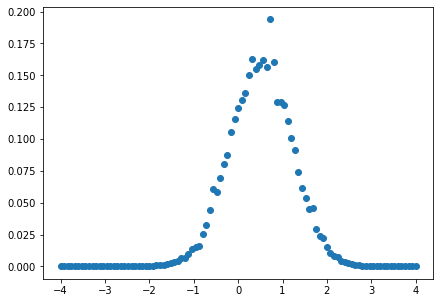

In [185]:
# z=0.5
xs = np.linspace(-4,4,101)
xs_2D = np.stack([xs, xs]).T.astype(np.float32)
zs = np.full((101,1), 0.5, dtype=np.float32)
#print(xs_2D)
#print(xs_2D.shape, zs.shape)
probs = model.conditional_prob(xs_2D, zs)
fig_xs_2 = plt.figure(figsize=(7,5))
plt.scatter(xs, probs)

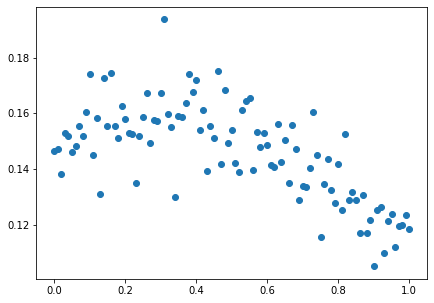

In [204]:
# Step 2: Plot p(x|z) as a function of z for fixed x.

fixed_x = [0.3,0.5]
zs = np.linspace(0,1,101).reshape((101,1)).astype(np.float32)
xs = np.full((101,2), fixed_x).astype(np.float32)
#print(xs.shape, zs.shape)
probs = model.conditional_prob(xs, zs)
fig_zs_1 = plt.figure(figsize=(7,5))
plt.scatter(zs, probs)

In [ ]:
# Step 3: Find z that maximizes p(x|z) by gradient descent
# How to get gradient of p(x|z) wrt z?

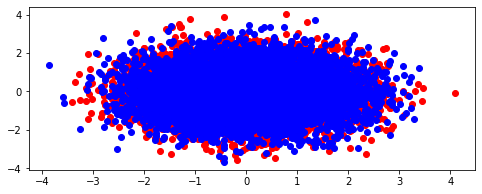

In [63]:
# Where in the base distribution are each of the double gaussians mapped to? 
# (Hint: draw samples from each gaussian separately and run the transformation backwards)

inversed_first = model.conditional_inverse(transformed_first, np.ones((NSAMPLES,1),dtype=np.float32))
inversed_second = model.conditional_inverse(transformed_second, np.zeros((NSAMPLES,1),dtype=np.float32))

fig2 = plt.figure(figsize=(8, 3))
plt.scatter(inversed_first[:, 0], inversed_first[:, 1], color="r")
plt.scatter(inversed_second[:, 0], inversed_second[:, 1], color="b")

In [90]:
# Imagine you started with a random point drawn from the 2-gaussian distribution. 
# How would you determine the conditional value this point belongs to? 
# (Hint: In the toy example, z can only assume 2 values z1, and z2, determine 
# the probability of p(x|z1) and p(x|z2))

random_point = transformed[0]
prob1 = model.conditional_prob([random_point], [[1.0]])
prob0 = model.conditional_prob([random_point], [[0.0]])
print(f"Prob1: {prob1}, Prob2: {prob0}, Random point: {random_point}")

prob1 = model.conditional_prob([random_point], [[1.0]])
prob0 = model.conditional_prob([random_point], [[0.0]])
print(f"Prob1: {prob1}, Prob2: {prob0}, Random point: {random_point}")

prob1 = model.conditional_prob([random_point], [[1.0]])
prob0 = model.conditional_prob([random_point], [[0.0]])
print(f"Prob1: {prob1}, Prob2: {prob0}, Random point: {random_point}")


# We see that the probability that Random Point belongs to the first distribution is nonzero,
# and the probability that it belongs to the second distribution is essentially 0.
# This point is at (0.076, 0.024), and is essentially at the center of the red (first)
# distribution, so our result makes sense.

# The reason why calling conditional_prob() many times gives different answers is that
# we are using an approximation to the trace. If we used the slower and exact function,
# then it would be deterministic.

Prob1: [0.74297625], Prob2: [3.7555317e-05], Random point: [0.07565676 0.02377819]
Prob1: [0.33040854], Prob2: [6.666122e-05], Random point: [0.07565676 0.02377819]
Prob1: [1.1889745], Prob2: [3.9869148e-05], Random point: [0.07565676 0.02377819]


In [89]:
model.flow

<tfp.distributions.TransformedDistribution 'chain_of_bijector3_of_bijector2_of_bijector1_of_bijector0MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>